In [14]:
### Importing public functions
import os
import sys
import importlib
import json
import csv
from abc import ABCMeta, abstractmethod
from dataclasses import dataclass, field, fields
from collections import namedtuple
from typing import Any
from itertools import compress
from pathlib import Path
import pandas as pd
import numpy as np
import sklearn as sk
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import ghostipy as gsp
from pacpy.pac import plv
from scipy import fftpack, stats
from array import array
import datetime as dt
import time
# #mne
# import mne_bids
# import mne


In [2]:
# define local storage directories
projectpath = '/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys'
codepath = os.path.join(projectpath, 'code')
fig_dir = os.path.join(projectpath, 'figures')
# pynmd_path = os.path.join(codepath, 'py_neuromodulation')

proc_data_path = os.path.join(projectpath, 'data/preprocessed_data')

ft_path = os.path.join(projectpath, 'code/lfpecog_features')
sys.path.append(ft_path)  # enable import in sub-functions




In [543]:
os.chdir(codepath)

# own functions
import lfpecog_features.feats_read_proc_data as read_data
import lfpecog_features.feats_helper_funcs as ftHelpers
import lfpecog_preproc.preproc_import_scores_annotations as importClin

import lfpecog_features.moveDetection_preprocess as movePrep
import lfpecog_features.moveDetection_run as run_tap_detect
import lfpecog_features.moveDetection_pausedTapFinder as findTap


import lfpecog_exploration.expl_plotting as expl_plot
# import lfpecog_features.handTap_detect as handTap_detect
# import lfpecog_features.handTap_detect2 as handTap_detect2
import lfpecog_features.feats_spectral_baseline as specBase
import lfpecog_features.feats_spectral_features as specFts
import lfpecog_features.feats_spectral_helpers as specHelpers
import lfpecog_features.feats_main as ftsMain
import lfpecog_features.feats_ftsExtr_Classes as ftClasses


os.chdir(projectpath)




In [4]:
print('Python (sys):', sys.version_info)
print('NumPy:', np.__version__)
print('pandas:', pd.__version__)
print('SciPy:', scipy.__version__)
### Sept 2022
# Python (sys): sys.version_info(major=3, minor=9, micro=7, releaselevel='final', serial=0)
# NumPy: 1.20.3
# pandas: 1.3.4
# SciPy: 1.7.1

Python (sys): sys.version_info(major=3, minor=9, micro=7, releaselevel='final', serial=0)
NumPy: 1.20.3
pandas: 1.3.4
SciPy: 1.7.1


### Custom new signal processing and plotting functions

In [296]:
def custom_round_array(
    array, resolution
):
    """
    Round an array on a custom
    resolution of choice.
    Works as well for single values
    
    Input:
        - array: array, list or single
            value to round
        - resolution: resolution to
            round on
    
    Returns:
        - round_array: resulting
            rounded array
    """
    if type(array) == list:
        array = np.array(array)
    
    round_array = np.around(
        array / resolution
    ) * resolution

    return round_array


In [289]:
def remove_duplicate_legend(
    legend_handles_labels
):
    """
    Input:
        - legend_handles_labels: output of
            plt.gca().get_legend_handles_labels()
    
    Returns:
        - handles, labels: without duplicates
    """
    labels = plt.gca().get_legend_handles_labels()[0]
    handles = plt.gca().get_legend_handles_labels()[1]
    
    singles = dict(zip(handles, labels))

    handles = singles.values()
    labels = singles.keys()

    return handles, labels

### 1. Patient-Run Definition and Processed Data Loading

In [5]:
# Import subjectData Classes with alligned preprocessed Data
importlib.reload(read_data)
subData = {}

for sub in ['012',  '014']:  # '013',
    subData[sub] = read_data.subjectData(
        sub=sub,
        data_version='v2.3',
        project_path=projectpath,
    )

In [7]:
# Develop clinical scores import
# TODO: merge into subjectData Classes df-rows
# TODO: tap-timings 94-columns), movement-timings (1-col), AIMS and CDRS classes
importlib.reload(importClin)

scores12, dopaTaps, _ = importClin.run_import_clinInfo(sub='012')

In [8]:
scores12

,dopa_time,AIMS_facial_oral,AIMS_upper_extr,AIMS_lower_extr,AIMS_trunk,AIMS_total,CDRS_face,CDRS_neck,CDRS_trunk,CDRS_upper_right,CDRS_upper_left,CDRS_lower_right,CDRS_lower_left,CDRS_total_right,CDRS_total_left,CDRS_total
0,0,0.0,2.0,2.0,1.0,5.0,0.0,0.0,1.0,2.0,1.0,2.0,1.0,4.0,2.0,7.0
1,10,0.0,1.0,1.0,1.0,3.0,0.0,0.0,1.0,2.0,1.0,2.0,1.0,4.0,2.0,7.0
2,20,1.0,3.0,3.0,3.0,10.0,1.0,2.0,3.0,4.0,2.0,4.0,2.0,8.0,4.0,18.0
3,30,1.0,3.0,4.0,2.0,10.0,1.0,2.0,2.0,4.0,3.0,4.0,3.0,8.0,6.0,19.0
4,40,1.0,3.0,4.0,2.0,10.0,0.0,1.0,2.0,3.0,2.0,4.0,2.0,7.0,4.0,14.0
5,50,1.0,3.0,4.0,2.0,10.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0,7.0,5.0,17.0
6,60,1.0,3.0,4.0,2.0,10.0,1.0,1.0,2.0,3.0,2.0,4.0,4.0,7.0,6.0,17.0
7,70,1.0,3.0,4.0,2.0,10.0,1.0,1.0,2.0,2.0,2.0,4.0,4.0,6.0,6.0,16.0


### Develop and Plot Movement Classification Functions

To merge into subjectData Classes:
- lists of lateralised tap timings (4 values per tap)
- list of lateralised other movement timings (one value / movement)

In [357]:
importlib.reload(run_tap_detect)
importlib.reload(movePrep)
importlib.reload(findTap)

taplists = {}
for sub in ['012',  '014']:  # '008', '013',
    print(sub)
    taplists[sub] = run_tap_detect.runTapDetection(subData[sub])

<module 'lfpecog_features.moveDetection_pausedTapFinder' from '/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys/code/lfpecog_features/moveDetection_pausedTapFinder.py'>

In [356]:
def create_timed_move_df(
    subdat, time_res
):
    """
    Create array and dataframe with
    detected bilateral movements and
    taps.
    Create from start- to end-time a timed
    dataframe with a defined resolution.

    Input:
        - subdat: subData class of subject
        - detected_moves (dict): subject's
            dict with detected taps/moves
        - time_res: time resolution of df
            in seconds
    
    Output:
        - timed_df (DataFrame): timed df
            assigning detected movements
            and taps on the requested time-
            resolution.
    """
    # run movement detection
    detected_moves = run_tap_detect.runTapDetection(subdat)

    # define keys for df
    arr_keys = [
        'dopa_time',
        'left_move',
        'right_move',
        'left_tap',
        'right_tap'
    ]
    # create time raster
    first_t = subdat.acc_left.data['dopa_time'].iloc[0]
    last_t = subdat.acc_left.data['dopa_time'].iloc[-1]

    t_rast = np.arange(round(first_t), last_t, time_res)[4:]
    # skip first values to avoid IndexError due to rounding

    # create empty rast to fill, based on times
    arr = np.zeros((len(t_rast), len(arr_keys)))
    arr[:, 0] = t_rast

    for col, key in enumerate(arr_keys):

        if col == 0: continue

        rounded_move_times = custom_round_array(
            detected_moves[f'{key}_t'], time_res
        )

        arr[:, col] = [
            t in rounded_move_times for t in arr[:, 0]
        ]

    df = pd.DataFrame(arr, columns=arr_keys)

    return df


### Visualise Overall Performance of Tap/Move-detection

In [254]:

fs=20

for sub in list(subData.keys()):

    for x0, x1 in zip(
        [-10, 20, 50],
        [20, 50, 80]
    ):

        fig, axes = plt.subplots(2, 1, figsize=(18, 8))

        for s, side in enumerate(['left', 'right']):

            ax = movePrep.find_main_axis(
                subData[sub].acc_left.data.iloc[:, 1:4].values
            )

            acc_df = getattr(subData[sub], f'acc_{side}').data  # per side
            
            axes[s].plot(
                acc_df['dopa_time'] / 60,
                acc_df.iloc[:, ax + 1],
                alpha=.4, label='uni-axis'
            )
            axes[s].plot(
                acc_df['dopa_time'] / 60,
                movePrep.signalvectormagn(
                    acc_df.iloc[:, 1:4].values
                ), alpha=.4, label='svm', c='r', ls='dotted',
            )

            axes[s].scatter(
                np.array([l[0] for l in taplists[sub][f'{side}_tap_t']]) / 60,
                [1e-6] * len(taplists[sub][f'{side}_tap_t']),
                s=50, color='g', label='tap-start',
            )
            axes[s].scatter(
                np.array([l[-1] for l in taplists[sub][f'{side}_tap_t']]) / 60,
                [1e-6] * len(taplists[sub][f'{side}_tap_t']),
                s=50, color='orange', label='tap-end'
            )

            axes[s].scatter(
                np.array(taplists[sub][f'{side}_move_t']) / 60,
                [.5e-6] * len(taplists[sub][f'{side}_move_t']),
                s=50, color='purple', label='movement'
            )

            axes[s].set_xlim(x0, x1)
            axes[s].set_ylim(-2e-6, 2e-6)
            axes[s].set_ylabel(
                f'Acceleration\n{side.upper()}'
                    '\n(g, m/s/s)',
                size=fs
            )
            axes[s].tick_params(labelsize=fs - 4)

        axes[s].set_xlabel('Time (minutes to L-Dopa intake)', size=fs)


        plt.suptitle(
            f'Subject {sub} -  bilateral '
            'Movement detection',
            x=.1, y=.96, ha='left',
            size=fs+4
        )
        # remove duplicate legend labels
        handles, labels = remove_duplicate_legend(
            plt.gca().get_legend_handles_labels()
        )

        fig.legend(
            handles, labels,
            frameon=False, fontsize=fs, ncol=3,
            loc='center left', bbox_to_anchor = [.55, .95])
        
        plt.tight_layout()

        plt.savefig(os.path.join(
            fig_dir, 'tapping_detection',
            f'sub{sub}_moveDetect_bilat_min{x0}_{x1}'
        ), dpi=150, facecolor='w',)

        plt.close()

#### Create timed dataframes with detected moves and taps

In [530]:
timedMoveDf = {}

for sub in list(subData.keys()):
    
    timedMoveDf[sub] = create_timed_move_df(
        subData[sub], time_res=.5
    )

start movement detection sub 012 left side
start movement detection sub 012 right side
start movement detection sub 014 left side
start movement detection sub 014 right side


### BaseLine creation

#### Spectral exploration new dataClass structure

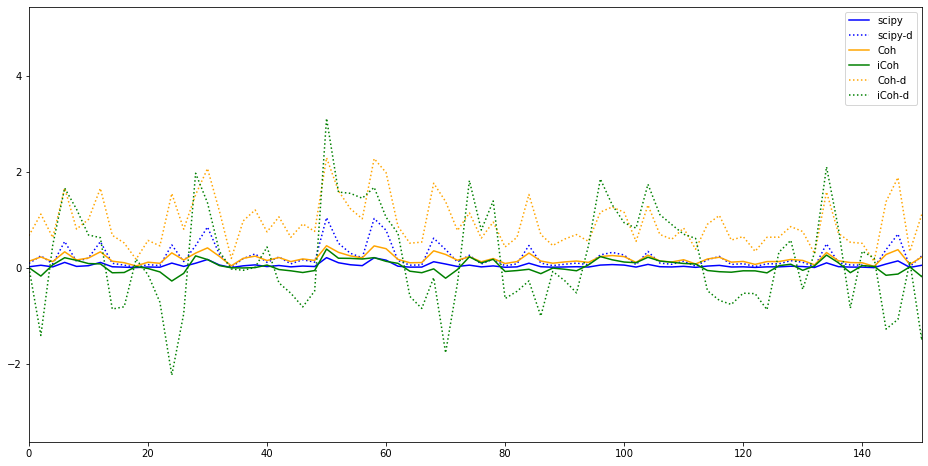

In [283]:
# i_range =  (16000, 30000)  # good: (16000, 40000)
# nperseg = 800
# noverlap=nperseg/2

# f, Px = signal.welch(
#     testdat0.values[i_range[0]:i_range[1]],
#     fs=1600, nperseg=nperseg, noverlap=noverlap,
# )
# f, Py = signal.welch(
#     testdat2.values[i_range[0]:i_range[1]],
#     fs=1600, nperseg=nperseg, noverlap=noverlap,
# )
# f, Pxy = signal.csd(
#     testdat0.values[i_range[0]:i_range[1]],
#     testdat2.values[i_range[0]:i_range[1]],
#     fs=1600, nperseg=nperseg, noverlap=noverlap,
# )
# fSc, cohSc = signal.coherence(
#     testdat0.values[i_range[0]:i_range[1]],
#     testdat2.values[i_range[0]:i_range[1]],
#     fs=1600, nperseg=nperseg, noverlap=noverlap,
# )
# coh1 = abs(Pxy) / np.sqrt(np.multiply(Px, Py))

# coherency = Pxy / np.sqrt(np.multiply(Px, Py))
# icoh = coherency.imag
# coh = abs(coherency)

# plt.figure(figsize=(16, 8))

# plt.plot(fSc, cohSc, label='scipy', c='b')
# plt.plot(fSc, cohSc / np.std(cohSc), label='scipy-d', c='b', ls='dotted')

# # plt.plot(f, coherency, label='coherency')

# plt.plot(f, coh, c='orange', label='Coh', )
# plt.plot(f, icoh, c='g', label='iCoh',)

# plt.plot(f, coh / np.std(coh), c='orange', label='Coh-d', ls='dotted')
# plt.plot(f, icoh / np.std(icoh), c='g', label='iCoh-d', ls='dotted')
# plt.legend()
# plt.xlim(0, 150)
# plt.show()

In [12]:
importlib.reload(specBase)
importlib.reload(specFts)
importlib.reload(movePrep)
importlib.reload(ftsMain)
importlib.reload(ftClasses)

subBl = {}

for sub in subData.keys():  # ['012', '013', '014']:

    print(f'\nSTART Sub {sub}\n')
    
    subBl[sub] = specBase.createBaseline(
        subData=subData[sub],
        n_bl_minutes=5,
        nSec_blWins=5,
        nSec_Segm=5,
    )


# TODO: remove time checks for time saving


START Sub 012

	BaseLine for lfp_left, LFP_L_1_2: 117 windows of 8000 samples (1600 Hz)
	BaseLine for lfp_left, LFP_L_2_3: 117 windows of 8000 samples (1600 Hz)
	BaseLine for ecog_right, ECOG_R_01: 118 windows of 8000 samples (1600 Hz)
	BaseLine for lfp_right, LFP_R_0_1: 118 windows of 8000 samples (1600 Hz)
	BaseLine for lfp_right, LFP_R_1_2: 118 windows of 8000 samples (1600 Hz)
	BaseLine for lfp_right, LFP_R_2_3: 118 windows of 8000 samples (1600 Hz)
	BaseLine for ecog_right, ECOG_R_02: 120 windows of 8000 samples (1600 Hz)
	BaseLine for lfp_right, LFP_R_0_1: 118 windows of 8000 samples (1600 Hz)
	BaseLine for lfp_right, LFP_R_1_2: 118 windows of 8000 samples (1600 Hz)
	BaseLine for lfp_right, LFP_R_2_3: 118 windows of 8000 samples (1600 Hz)
	BaseLine for ecog_right, ECOG_R_03: 119 windows of 8000 samples (1600 Hz)
	BaseLine for lfp_right, LFP_R_0_1: 118 windows of 8000 samples (1600 Hz)
	BaseLine for lfp_right, LFP_R_1_2: 118 windows of 8000 samples (1600 Hz)
	BaseLine for lfp_rig

In [181]:
importlib.reload(specBase)
importlib.reload(specFts)
importlib.reload(movePrep)
importlib.reload(ftsMain)
importlib.reload(ftClasses)

# subFts = {}
shortFts = {}

for sub in list(subBl.keys())[:1]:

    shortFts[sub] = ftsMain.create_dopaTimed_ftSpace(
        sub=sub,
        subData=subData[sub],
        subBaseline=subBl[sub],
        window_len=1,  # in seconds
        win_overlap=.5,  # relative to window_len
    )
# PM: ECOG-STN features most computational heavy (10s windows: 012 and 014 1m43s)
# 1s window: 18s one lfp side; 4m30s ecog

	lfp_left finished (012)
	ecog_right finished (012)
	lfp_right finished (012)

	Finished 012



In [40]:
from mne import filter


baseline info: dict_keys(['winData', 'winTimes', 'fs', 'nperseg', 'overlap', 'incl_psd', 'incl_wav', 'win_tasks', 'psd_f', 'psd'])
time mne filtering: 0.05917137599681155
time scipy filtering: 0.009161601999949198


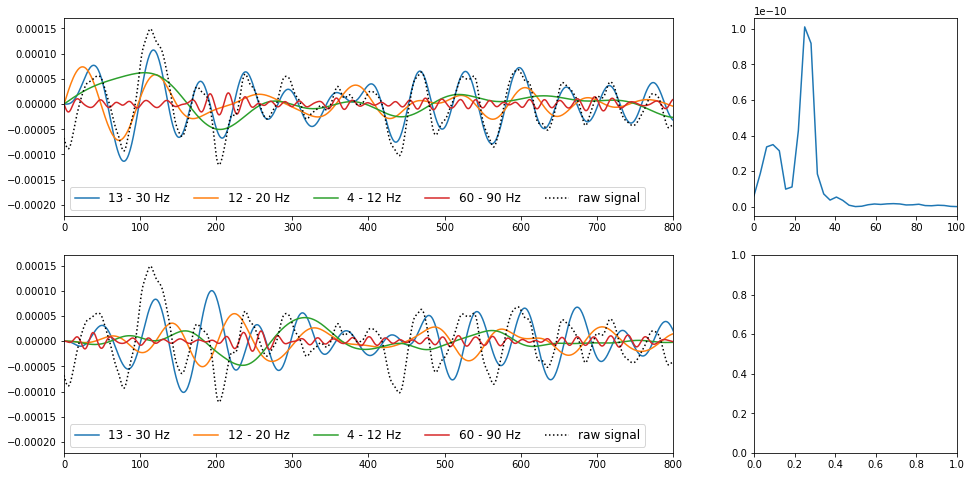

In [75]:
# available in baseline info
print(
    'baseline info:',
    vars(subBl['012'].ECOG_R_01).keys()
)

sub = '012'
ch = 'ECOG_R_01'
win_i = 100
sig = getattr(subBl[sub], ch)
sigWin = sig.winData[win_i]

fig, axes = plt.subplots(
    2, 2, figsize=(16, 8),
    gridspec_kw={'width_ratios': [3, 1]}
)


# Work FURTHER -> FILTER OUT BETA AND GAMMA SIGNALS;
# CONSTRCUTS BETA AND GAMMA BURSTS
t0 = time.perf_counter()
for freqs in [
    [13, 30],
    [12, 20],
    [4, 12],
    [60, 90]
]:

    filtWinSig = filter.filter_data(
        sigWin,
        sfreq=sig.fs,
        l_freq=freqs[0],
        h_freq=freqs[1],
        verbose=False
    )
    axes[0, 0].plot(
        filtWinSig,
        label=f'{freqs[0]} - {freqs[1]} Hz'
    )
t1 = time.perf_counter()
print('time mne filtering:', t1-t0)

t0 = time.perf_counter()

for freqs in [
    [13, 30],
    [12, 20],
    [4, 12],
    [60, 90]
]:
    # FIR filter scipy
    filtSig2 = specFts.bandpass(
        sig=sigWin,
        fs=sig.fs,
        freqs=freqs,
    )
    axes[1, 0].plot(
        filtSig2,
        label=f'{freqs[0]} - {freqs[1]} Hz'
    )
t1 = time.perf_counter()
print('time scipy filtering:', t1-t0)


# general first row
for ax in [0, 1]:
    axes[ax, 0].plot(sigWin, label='raw signal',
    c='k', ls='dotted',)
    axes[ax, 0].legend(ncol=5, fontsize=12)
    axes[ax, 0].set_xlim(0, 800)
    

    

f, psd = signal.welch(
    sigWin[:1600], fs=sig.fs, nperseg=512,
)
axes[0, 1].plot(f, psd)
axes[0, 1].set_xlim(0, 100)


plt.show()


In [456]:
print(vars(shortFts['012'].ecog_right.ECOG_R_01).keys())

shortFts['012'].ecog_right.ECOG_R_01_LFP_R_0_1.icoh.shape
shortFts['012'].ecog_right.ECOG_R_01.psd.shape

dict_keys(['winData', 'winTimes', 'fs', 'nperseg', 'overlap', 'incl_psd', 'incl_wav', 'win_tasks', 'psd_f', 'psd'])


(6726, 401)

In [ ]:
### VISUALISE some PSDs over Time

"""
WORK FURTHER ON THIS CONCEPT

INCLUDE ONLY REST-NO MOVEMENT PARTS
"""
# winData (per contact) has:
#   n rows for n windows,
#   every row is signal in window (n samples = win_len * fs)

sub = '012'
source = 'ecog_right'
# chNames = [
#     'LFP_R_0_1', 'LFP_R_1_2', 'LFP_R_2_3',
#      'LFP_L_1_2', 'LFP_L_2_3'
# ]
chNames = [f'ECOG_R_0{n}' for n in range(1, 7)]
hop = 250

fig, axes = plt.subplots(
    # len(chNames), 1,
    3, 2,
    # sharex=True,
    figsize=(12, 12),
)
axes = axes.flatten()

for ax_n, ch_name in enumerate(chNames):

    try:
        ftSource = getattr(shortFts[sub], source)
        ftCh = getattr(ftSource, ch_name)
    except:
        ftSource = getattr(shortFts[sub], 'lfp_left')
        ftCh = getattr(ftSource, ch_name)

    for n, w in enumerate(
        np.arange(0, len(ftCh.winTimes), hop)
    ):
        
        psSel, fSel = specHelpers.select_bandwidths(
            values=ftCh.psd[w],
            freqs=ftCh.psd_f,
            f_min=1, f_max=101,
        )
        psSel = specHelpers.relative_power(psSel)

        alpha = n * .03
        if alpha > 1: alpha = 1
        axes[ax_n].plot(
            fSel, psSel,
            c='b', alpha=alpha,
            label=f'{round(ftCh.winTimes[w] / 60, 1)} m'
        )

    axes[ax_n].set_xlim(0, 90)
    axes[ax_n].set_xlabel('Frequency (Hz)')
    axes[ax_n].set_ylabel('Relative PSD')
    axes[ax_n].set_title(ch_name)

    axes[ax_n].legend(
        frameon=False, ncol=3,
        loc='upper right',
        fontsize=8,
    )

plt.tight_layout()

# plt.savefig(
#     os.path.join(
#         fig_dir, 'ft_exploration', 'PSD',
#         f'{sub}_ECoG_relPsd_temporalCourse'
#     ), dpi=150, facecolor='w',
# )


plt.show()

In [499]:
importlib.reload(specHelpers)

<module 'lfpecog_features.feats_spectral_helpers' from '/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys/code/lfpecog_features/feats_spectral_helpers.py'>

In [573]:
col_df = pd.DataFrame(
    data=np.nanmean(ps_beta, axis=1),
    index=ftCh.winTimes
)
# ftHelpers.nan_array([frame_arr.shape[0], 1])

merge1 = pd.concat([frame_df, col_df], axis=1)  # include also index in right, not in left

merge2 = frame_df.join(col_df)  # only includes indeices of left

print(merge1.shape, merge2.shape)

(9633, 5) (9629, 5)


/var/folders/7d/4ptht2m910d1y872jrgp9cq40000gp/T/ipykernel_1030/1846116680.py:2: RuntimeWarning: Mean of empty slice
  data=np.nanmean(ps_beta, axis=1),


In [574]:
merge2

,left_move,right_move,left_tap,right_tap,0
dopa_time,,,,,
-534.0,0.0,0.0,0.0,0.0,0.019079
-533.5,0.0,0.0,0.0,0.0,0.033544
-533.0,0.0,1.0,0.0,0.0,0.019199
-532.5,0.0,0.0,0.0,0.0,0.017946
-532.0,0.0,0.0,0.0,0.0,0.037098
...,...,...,...,...,...
4278.0,0.0,0.0,0.0,0.0,NaN
4278.5,0.0,0.0,0.0,0.0,NaN
4279.0,0.0,1.0,0.0,0.0,NaN


In [563]:
frame_df = timedMoveDf['012'].set_index('dopa_time')
frame_arr = frame_df.values
# frame_arr = np.hstack([
#     frame_arr,
    
# ])

# frame_arr[:, -1] = [
#     v if t in ftCh.winTimes for v, t in zip([
#         arr[:, 0], np.mean(ps_beta, axis=1)
#     ])
# ]

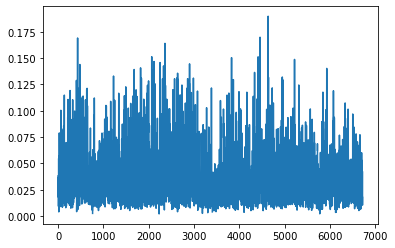

[-536.0,
 -535.5,
 -535.0,
 -534.5,
 -534.0,
 -533.5,
 -533.0,
 -532.5,
 -532.0,
 -531.5,
 -531.0,
 -530.5,
 -530.0,
 -529.5,
 -529.0,
 -528.5,
 -528.0,
 -527.5,
 -527.0,
 -526.5,
 -526.0,
 -525.5,
 -525.0,
 -524.5,
 -524.0,
 -523.5,
 -523.0,
 -522.5,
 -522.0,
 -521.5,
 -521.0,
 -520.5,
 -520.0,
 -519.5,
 -519.0,
 -518.5,
 -518.0,
 -517.5,
 -517.0,
 -516.5,
 -516.0,
 -515.5,
 -515.0,
 -514.5,
 -514.0,
 -513.5,
 -513.0,
 -512.5,
 -512.0,
 -511.5,
 -511.0,
 -510.5,
 -510.0,
 -509.5,
 -509.0,
 -508.5,
 -508.0,
 -507.5,
 -507.0,
 -506.5,
 -506.0,
 -505.5,
 -505.0,
 -504.5,
 -504.0,
 -503.5,
 -503.0,
 -502.5,
 -502.0,
 -501.5,
 -501.0,
 -500.5,
 -500.0,
 -499.5,
 -499.0,
 -498.5,
 -498.0,
 -497.5,
 -497.0,
 -496.5,
 -496.0,
 -495.5,
 -495.0,
 -494.5,
 -494.0,
 -493.5,
 -493.0,
 -492.5,
 -492.0,
 -491.5,
 -491.0,
 -490.5,
 -490.0,
 -489.5,
 -489.0,
 -488.5,
 -488.0,
 -487.5,
 -487.0,
 -486.5,
 -486.0,
 -485.5,
 -485.0,
 -484.5,
 -484.0,
 -483.5,
 -483.0,
 -482.5,
 -482.0,
 -481.5,
 -481.0,
 

In [529]:

psSel, fSel = specHelpers.select_bandwidths(
    values=ftCh.psd,
    freqs=ftCh.psd_f,
    f_min=1, f_max=101,
)
relPs = specHelpers.relative_power(psSel)

ps_beta, f_beta = specHelpers.select_bandwidths(
    values=relPs,
    freqs=fSel,
    f_min=14, f_max=21,
)

plt.plot(np.mean(ps_beta, axis=1))
plt.show()

ftCh.winTimes

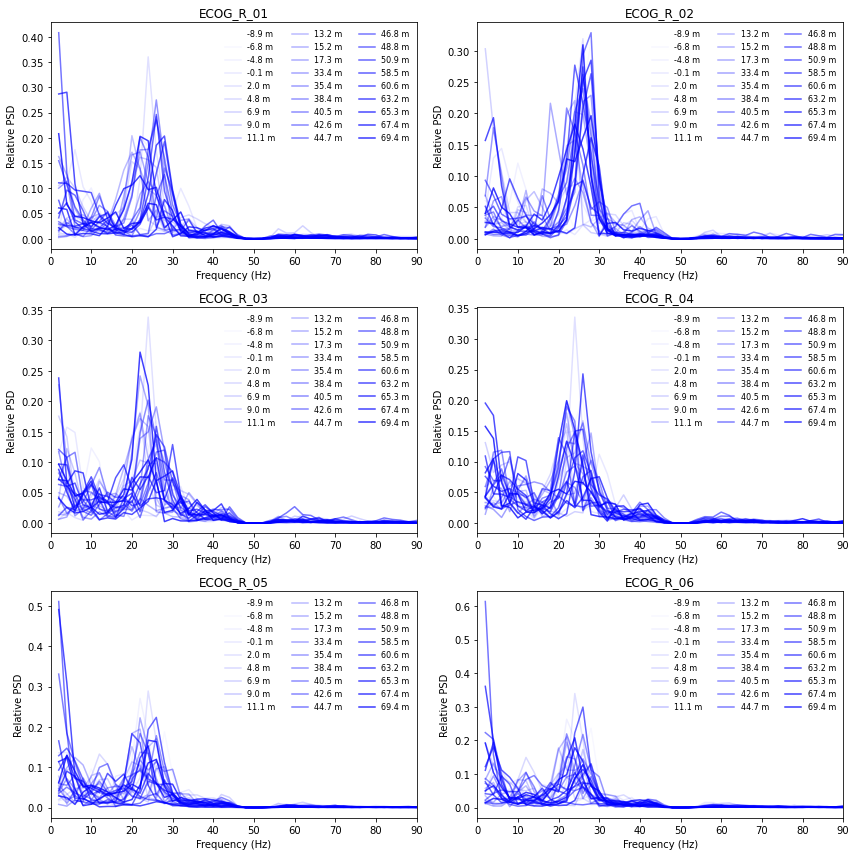

In [436]:
### visualise SPECTRAL BANDS over TIME

"""
WORK FURTHER ON THIS CONCEPT

INCLUDE ONLY REST-NO MOVEMENT PARTS
"""

sub = '012'
source = 'ecog_right'
# chNames = [
#     'LFP_R_0_1', 'LFP_R_1_2', 'LFP_R_2_3',
#      'LFP_L_1_2', 'LFP_L_2_3'
# ]
chNames = [f'ECOG_R_0{n}' for n in range(1, 7)]
hop = 250

fig, axes = plt.subplots(
    len(chNames), 1,
    # 3, 2,
    # sharex=True,
    figsize=(12, 12),
)
axes = axes.flatten()

for ax_n, ch_name in enumerate(chNames):

    try:
        ftSource = getattr(shortFts[sub], source)
        ftCh = getattr(ftSource, ch_name)
    except:
        ftSource = getattr(shortFts[sub], 'lfp_left')
        ftCh = getattr(ftSource, ch_name)

    for n, w in enumerate(
        np.arange(0, len(ftCh.winTimes), hop)
    ):
        
        psSel, fSel = specHelpers.select_bandwidths(
            values=ftCh.psd[w],
            freqs=ftCh.psd_f,
            f_min=1, f_max=101,
        )
        psSel = specHelpers.relative_power(psSel)

        alpha = n * .03
        if alpha > 1: alpha = 1
        axes[ax_n].plot(
            fSel, psSel,
            c='b', alpha=alpha,
            label=f'{round(ftCh.winTimes[w] / 60, 1)} m'
        )

    axes[ax_n].set_xlim(0, 90)
    axes[ax_n].set_xlabel('Frequency (Hz)')
    axes[ax_n].set_ylabel('Relative PSD')
    axes[ax_n].set_title(ch_name)

    axes[ax_n].legend(
        frameon=False, ncol=3,
        loc='upper right',
        fontsize=8,
    )

plt.tight_layout()

# plt.savefig(
#     os.path.join(
#         fig_dir, 'ft_exploration', 'PSD',
#         f'{sub}_ECoG_relPsd_temporalCourse'
#     ), dpi=150, facecolor='w',
# )


plt.show()

In [29]:
### Show available features
print(
    '\n\tSingle channel features:',
    vars(subFts['012'].lfp_right.LFP_R_0_1).keys()
)
print(
    '\n\tECoG-STN features:',
    vars(subFts['012'].ecog_right.ECOG_R_01_LFP_R_0_1).keys()
)


	Single channel features: dict_keys(['winData', 'winTimes', 'fs', 'nperseg', 'overlap', 'incl_psd', 'incl_wav', 'win_tasks', 'psd_f', 'psd'])

	ECoG-STN features: dict_keys(['ecogCh', 'ecogDat', 'ecogTimes', 'stnCh', 'stnDat', 'stnTimes', 'fs', 'nperseg', 'overlap', 'extr_baseline', 'combiCh_baseline', 'ecogTasks', 'freqs', 'icoh', 'coh', 'coh_times', 'coh_tasks', 'coh_dtc', 'icoh_dtc'])


(4.0, 30.0)

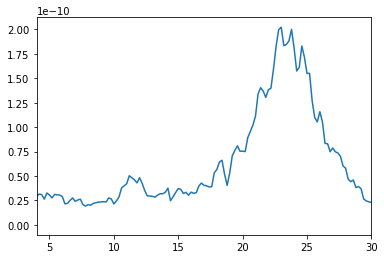

In [126]:
plt.plot(
    subBl['012'].ECOG_R_01.psd_f,
    np.mean(subBl['012'].ECOG_R_01.psd, axis=0)
)
plt.xlim(4, 30)


In [219]:
subData['012'].sub

'012'

In [ ]:
def arr_nanrange(
    array
):
    """
    Gives array of value-ranges from
    an array of 
    """
    min = 

    return 

In [165]:
arr_range = np.nanmax(sel_cohs, axis=1
    ) - np.nanmin(sel_cohs, axis=1
)

print(
    sel_cohs.shape,
    arr_range.shape
)



(487, 14) (487,)


/var/folders/7d/4ptht2m910d1y872jrgp9cq40000gp/T/ipykernel_1030/635849389.py:1: RuntimeWarning: All-NaN slice encountered
  arr_range = np.nanmax(sel_cohs, axis=1
/var/folders/7d/4ptht2m910d1y872jrgp9cq40000gp/T/ipykernel_1030/635849389.py:2: RuntimeWarning: All-NaN slice encountered
  ) - np.nanmin(sel_cohs, axis=1


In [195]:
vars(shortFts['012'].lfp_right.LFP_R_0_1).keys()

dict_keys(['winData', 'winTimes', 'fs', 'nperseg', 'overlap', 'incl_psd', 'incl_wav', 'win_tasks', 'psd_f', 'psd'])

In [217]:
np.where(np.around(subData['012'].lfp_right.data['dopa_time'], 0) ==  s)[0][0]

1015200

In [218]:
present_secs = np.around(
    subData['012'].lfp_right.data['dopa_time'], 0
).unique()

for s in present_secs:
    print(np.where(np.around(subData['012'].lfp_right.data['dopa_time'], 0) ==  s)[0][0])

0
800
2400
4000
5600
7200
8800
10400
12000
13600
15200
16800
18400
20000
21600
23200
24800
26400
28000
29600
31200
32800
34400
36000
37600
39200
40800
42400
44000
45600
47200
48800
50400
52000
53600
55200
56800
58400
60000
61600
63200
64800
66400
68000
69600
71200
72800
74400
76000
77600
79200
80800
82400
84000
85600
87200
88800
90400
92000
93600
95200
96800
98400
100000
101600
103200
104800
106400
108000
109600
111200
112800
114400
116000
117600
119200
120800
122400
124000
125600
127200
128800
130400
132000
133600
135200
136800
138400
140000
141600
143200
144800
146400
148000
149600
151200
152800
154400
156000
157600
159200
160800
162400
164000
165600
167200
168800
170400
172000
173600
175200
176800
178400
180000
181600
183200
184800
186400
188000
189600
191200
192800
194400
196000
197600
199200
200800
202400
204000
205600
207200
208800
210400
212000
213600
215200
216800
218400
220000
221600
223200
224800
226400
228000
229600
231200
232800
234400
236000
237600
239200
240800
242400
244

KeyboardInterrupt: 

In [212]:
present_secs = np.around(
    subData['012'].lfp_right.data['dopa_time'], 0
).unique()

for s in present_secs:
    print(np.argmin(abs(subData['012'].lfp_right.data['dopa_time'] - s)))

0
1600
3200
4800
6400
8000
9600
11200
12800
14400
16000
17600
19200
20800
22400
24000
25600
27200
28800
30400
32000
33600
35200
36800
38400
40000
41600
43200
44800
46400
48000
49600
51200
52800
54400
56000
57600
59200
60800
62400
64000
65600
67200
68800
70400
72000
73600
75200
76800
78400
80000
81600
83200
84800
86400
88000
89600
91200
92800
94400
96000
97600
99200
100800
102400
104000
105600
107200
108800
110400
112000
113600
115200
116800
118400
120000
121600
123200
124800
126400
128000
129600
131200
132800
134400
136000
137600
139200
140800
142400
144000
145600
147200
148800
150400
152000
153600
155200
156800
158400
160000
161600
163200
164800
166400
168000
169600
171200
172800
174400
176000
177600
179200
180800
182400
184000
185600
187200
188800
190400
192000
193600
195200
196800
198400
200000
201600
203200
204800
206400
208000
209600
211200
212800
214400
216000
217600
219200
220800
222400
224000
225600
227200
228800
230400
232000
233600
235200
236800
238400
240000
241600
243200
24

KeyboardInterrupt: 

In [204]:
shortFts['012'].lfp_right.LFP_R_0_1.winTimes


[-536.0,
 -535.5,
 -535.0,
 -534.5,
 -534.0,
 -533.5,
 -533.0,
 -532.5,
 -532.0,
 -531.5,
 -531.0,
 -530.5,
 -530.0,
 -529.5,
 -529.0,
 -528.5,
 -528.0,
 -527.5,
 -527.0,
 -526.5,
 -526.0,
 -525.5,
 -525.0,
 -524.5,
 -524.0,
 -523.5,
 -523.0,
 -522.5,
 -522.0,
 -521.5,
 -521.0,
 -520.5,
 -520.0,
 -519.5,
 -519.0,
 -518.5,
 -518.0,
 -517.5,
 -517.0,
 -516.5,
 -516.0,
 -515.5,
 -515.0,
 -514.5,
 -514.0,
 -513.5,
 -513.0,
 -512.5,
 -512.0,
 -511.5,
 -511.0,
 -510.5,
 -510.0,
 -509.5,
 -509.0,
 -508.5,
 -508.0,
 -507.5,
 -507.0,
 -506.5,
 -506.0,
 -505.5,
 -505.0,
 -504.5,
 -504.0,
 -503.5,
 -503.0,
 -502.5,
 -502.0,
 -501.5,
 -501.0,
 -500.5,
 -500.0,
 -499.5,
 -499.0,
 -498.5,
 -498.0,
 -497.5,
 -497.0,
 -496.5,
 -496.0,
 -495.5,
 -495.0,
 -494.5,
 -494.0,
 -493.5,
 -493.0,
 -492.5,
 -492.0,
 -491.5,
 -491.0,
 -490.5,
 -490.0,
 -489.5,
 -489.0,
 -488.5,
 -488.0,
 -487.5,
 -487.0,
 -486.5,
 -486.0,
 -485.5,
 -485.0,
 -484.5,
 -484.0,
 -483.5,
 -483.0,
 -482.5,
 -482.0,
 -481.5,
 -481.0,
 

/var/folders/7d/4ptht2m910d1y872jrgp9cq40000gp/T/ipykernel_1030/2094248263.py:37: RuntimeWarning: Mean of empty slice
  np.nanmean(sel_cohs, axis=1)[i_task],
/var/folders/7d/4ptht2m910d1y872jrgp9cq40000gp/T/ipykernel_1030/2094248263.py:45: RuntimeWarning: Mean of empty slice
  np.nanmean(sel_cohs, axis=1)[i_task],


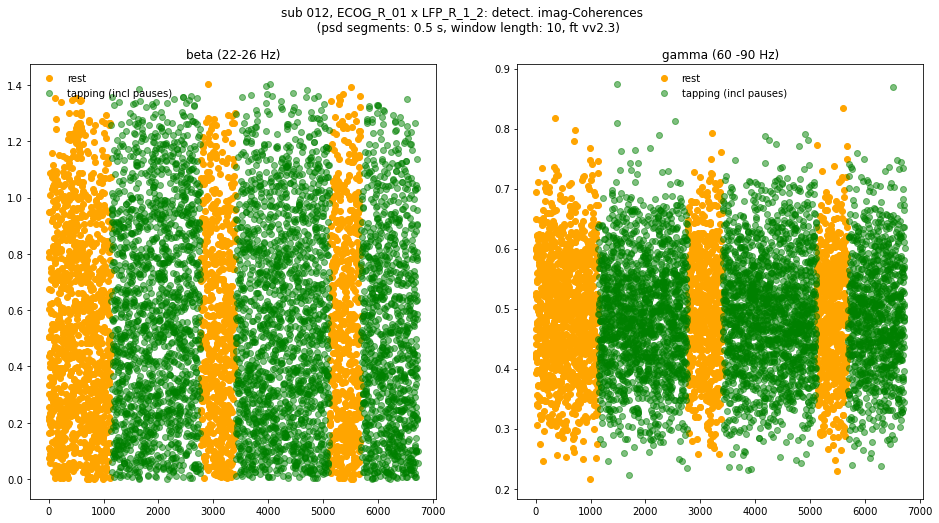

In [202]:
sub = '012'
ft_sel = 'icoh_dtc'
loc = 'ecog_right'
chEcog = 'ECOG_R_01'
chStn = 'LFP_R_1_2'
freq_sel = [13, 30]

tempFts = getattr(shortFts[sub], loc)
tempCh = getattr(tempFts, f'{chEcog}_{chStn}')
tempTasks = getattr(tempCh, 'coh_tasks')

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

importlib.reload(specHelpers)

for n, (freq_sel, lab) in enumerate(
    zip(
        [[22, 26], [60, 90]],
        [
            'beta (22-26 Hz)',
            'gamma (60 -90 Hz)'
        ]
    )
    
):

    sel_cohs, sel_f = specHelpers.select_bandwidths(
        getattr(tempCh, ft_sel)[:, 0, :],
        getattr(tempCh, 'freqs'),
        freq_sel[0], freq_sel[1]
    )

    i_task = [t == 'rest' for t in tempTasks ]

    axes[n].scatter(
        np.arange(0, sel_cohs.shape[0])[i_task],
        np.nanmean(sel_cohs, axis=1)[i_task],
        color='orange', label='rest',
    )

    i_task = [t == 'tap' for t in tempTasks ]

    axes[n].scatter(
        np.arange(0, sel_cohs.shape[0])[i_task],
        np.nanmean(sel_cohs, axis=1)[i_task],
        color='green', alpha=.5,
        label='tapping (incl pauses)',
    )

    axes[n].legend(
        frameon=False,
    )
    axes[n].set_title(f'{lab}')
    # axes[n].set_ylim(0, .35)

plt.suptitle(
    f'sub {sub}, {chEcog} x {chStn}: detect. imag-Coherences'
    f'\n   (psd segments: {subFts[sub].nSec_Seg} s, '
    f'window length: {subFts[sub].window_len}, '
    f'ft v{subFts[sub].subData.data_version})'
)

# plt.savefig(
#     os.path.join(
#         fig_dir, 'ft_exploration', 'coherence',
#         f'{sub}_{ft_sel}_dopaTime_{chEcog}_{chStn}'
#     ),
#     dpi=150, facecolor='w',
# )

plt.show()

### TODO:
#   plot several combinations ECOG-STN
#   ADD acc data (tap/no tap/ dysk)

In [141]:
print(vars(subFts['012']).keys()
)
subFts['012'].subData.data_version

dict_keys(['sub', 'window_len', 'win_overlap', 'subData', 'subBaseline', 'n_bl_minutes', 'lfp_left', 'ecog_right', 'lfp_right'])


'v2.3'

In [135]:
fig_dir

'/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys/figures'

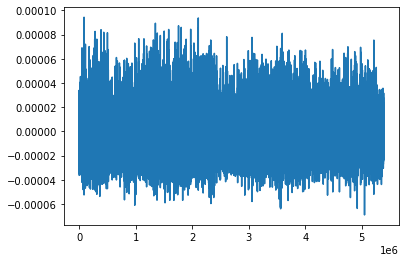

In [38]:
plt.plot(subData['012'].ecog_right.data['ECOG_R_03'])

In [60]:
print('lfp:', vars(subFts['012'].lfp_right.LFP_R_1_2).keys())
print()
print('ecog:', vars(subFts['012'].ecog_right.ECOG_R_01).keys())
print()
print('ecog-lfp:', vars(subFts['012'].ecog_right.ECOG_R_01_LFP_R_1_2).keys())

lfp: dict_keys(['winData', 'winTimes', 'fs', 'nperseg', 'overlap', 'incl_psd', 'incl_wav', 'psd_f', 'psd'])

ecog: dict_keys(['winData', 'winTimes', 'fs', 'nperseg', 'overlap', 'incl_psd', 'incl_wav', 'psd_f', 'psd'])

ecog-lfp: dict_keys(['ecogCh', 'ecogDat', 'ecogTimes', 'stnCh', 'stnDat', 'stnTimes', 'fs', 'nperseg', 'overlap', 'extr_baseline', 'combiCh_baseline', 'freqs', 'icoh', 'coh', 'coh_times', 'coh_dtc', 'icoh_dtc'])


In [75]:
subFts['012'].ecog_right.ECOG_R_01.psd_f.shape

(401,)

In [57]:
subData['012'].ecog_right.data.keys()

Index(['dopa_time', 'ECOG_R_01', 'ECOG_R_02', 'ECOG_R_03', 'ECOG_R_04',
       'ECOG_R_05', 'ECOG_R_06', 'task'],
      dtype='object')

### VIsualisation Features

In [97]:
freqs = getattr(subFts[sub].ecog_left, 'ECOG_R_01_LFP_R_1_2').freqs
coh = getattr(subFts[sub].ecog_left, 'ECOG_R_01_LFP_R_1_2').icoh[:, 0, :]

NameError: name 'subFts' is not defined

/var/folders/7d/4ptht2m910d1y872jrgp9cq40000gp/T/ipykernel_87636/294449591.py:14: RuntimeWarning: Mean of empty slice
  np.nanmean(coh[:, sel[fsel]], axis=1)


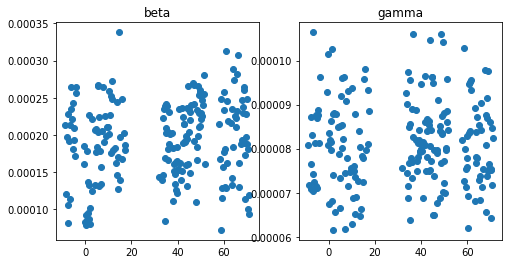

In [915]:
sel = {
    'beta': [13 <= f <= 30 for f in freqs],
    'gamma': [60 <= f <= 150 for f in freqs]
}
f_sel = freqs[sel['beta']]
icoh_sel = coh[:, sel['beta']]

fig, axes = plt.subplots(1, len(sel), figsize=(8, 4))

for n, fsel in enumerate(sel.keys()):

    axes[n].scatter(
        winTimes / 60,
        np.nanmean(coh[:, sel[fsel]], axis=1)
    )
    axes[n].set_title(fsel)

plt.show()

# plt.plot(
#     winTimes[:600] / 60,
#     subData[sub].ecog_left.data['task'][::9000]
# )

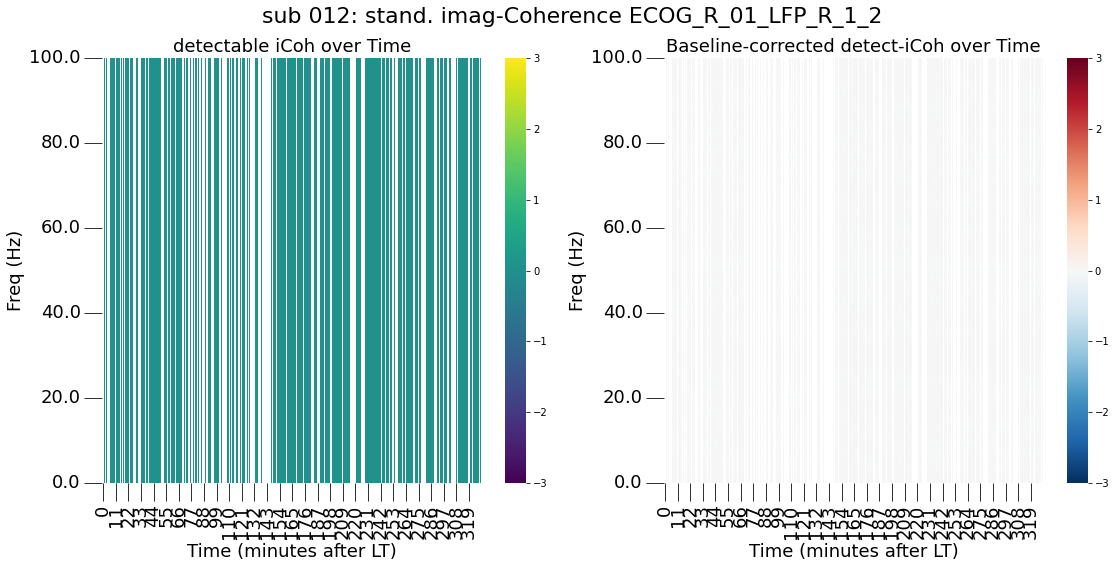

In [906]:
### PLOT FT_FIGURES !!!!

# Define sub and ephys-channel
sub = '012'
ch = 'ECOG_R_01_LFP_R_1_2'

coh = getattr(subFts[sub].ecog_left, ch).icoh_dtc[:, 0, :]  # 3d -> 2d
freqs = getattr(subFts[sub].ecog_left, ch).freqs
winTimes = np.array(getattr(subFts[sub].ecog_left, ch).coh_times)
# Correct raw PSD for baseline
coh_bl = getattr(subBl[sub], ch).icoh_dtc[:, 0, :]  # 3d -> 2d
coh_bl = np.mean(coh_bl, axis=0)

cohC = coh - coh_bl

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

fs=18

f1 = sns.heatmap(
    coh.T,
    cmap='viridis',
    vmin=-3, vmax=3,
    ax=axes[0],
)
f2 = sns.heatmap(
    cohC.T,
    cmap='RdBu_r',
    vmin=-3, vmax=3,
    # vmin=-1, vmax=1,
    ax=axes[1],
)
# axes[0].set_ylim(0, psd_sel.shape[0])
for ax in axes:

    ax.set_yticks(
        np.arange(len(freqs))[::10]
    )
    ax.set_yticklabels(
        freqs[::10], rotation=0,
    )
    ax.set_ylabel(
        'Freq (Hz)', size=fs,
    )

    # ax.set_xticks(
    #     np.arange(0, coh.shape[1], 100)
    # )
    # ax.set_xticklabels(
    #     np.around(winTimes[::100] / 60),
    #     rotation=0,
    # )
    ax.set_xlabel(
        'Time (minutes after LT)', size=fs,
    )

    ax.set_ylim(0, 50)

    ax.tick_params(
        axis='both', which='major',
        labelsize=fs, size=fs
    )

axes[0].set_title(
    'detectable iCoh over Time', size=fs,
)
axes[1].set_title(
    'Baseline-corrected detect-iCoh over Time', size=fs,
)

plt.suptitle(f'sub {sub}: stand. imag-Coherence {ch}', size=fs+4)

plt.tight_layout()

figname = f'{sub}_'
plt.savefig(
    os.path.join(fig_dir, 'ft_exploration', figname),
    dpi=150, facecolor='w',
)

plt.show()

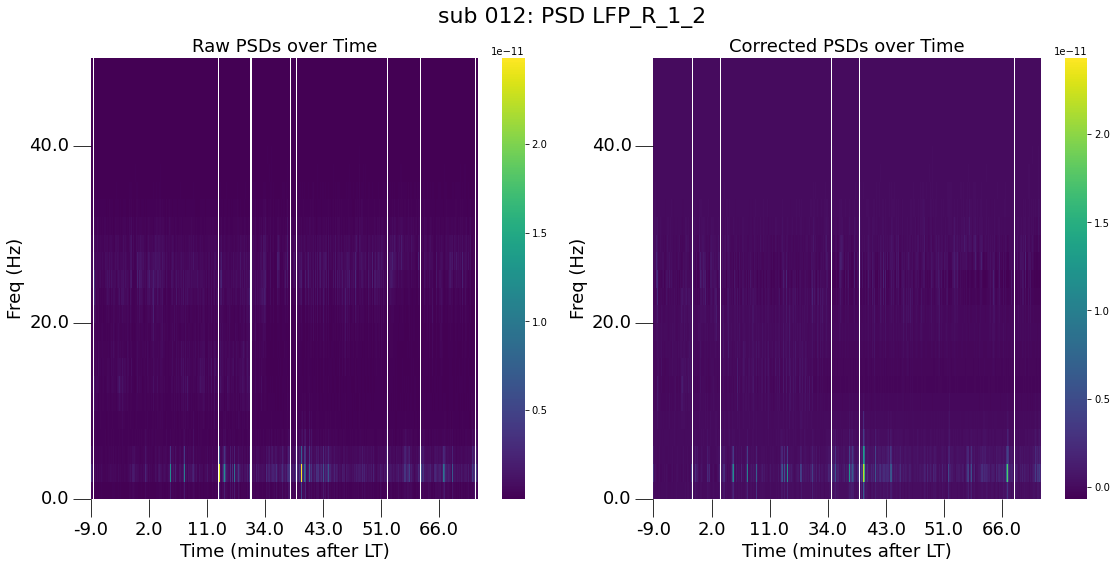

In [769]:
# Define sub and ephys-channel
sub = '012'
ch='LFP_R_1_2'

psds = getattr(subFts[sub].lfp_right, ch).psd
freqs = getattr(subFts[sub].lfp_right, ch).psd_f
winTimes = np.array(getattr(subFts[sub].lfp_right, ch).blTimes)
# Correct raw PSD for baseline
mean_blPsd = np.mean(getattr(subBl[sub], ch).psd, axis=0)
psdsC = psds - mean_blPsd

# Select freq range to show
sel = [f <= 200 for f in freqs]
f_sel = freqs[sel]
psds_sel = psds[:, sel].T
psdsC_sel = psdsC[:, sel].T



fig, axes = plt.subplots(1, 2, figsize=(16, 8))

fs=18

f1 = sns.heatmap(
    psds_sel,
    cmap='viridis',
    ax=axes[0],
)
f2 = sns.heatmap(
    psdsC_sel,
    cmap='viridis',
    ax=axes[1],
)
# axes[0].set_ylim(0, psd_sel.shape[0])
for ax in axes:

    ax.set_yticks(
        np.arange(len(f_sel))[::10]
    )
    ax.set_yticklabels(
        f_sel[::10], rotation=0,
    )
    ax.set_ylabel(
        'Freq (Hz)', size=fs,
    )

    ax.set_xticks(
        np.arange(0, psd_sel.shape[1], 100)
    )
    ax.set_xticklabels(
        np.around(winTimes[::100] / 60),
        rotation=0,
    )
    ax.set_xlabel(
        'Time (minutes after LT)', size=fs,
    )

    ax.set_ylim(0, 25)

    ax.tick_params(
        axis='both', which='major',
        labelsize=fs, size=fs
    )

axes[0].set_title(
    'Raw PSDs over Time', size=fs,
)
axes[1].set_title(
    'Corrected PSDs over Time', size=fs,
)

plt.suptitle(f'sub {sub}: PSD {ch}')


plt.tight_layout()
plt.show()

### VISUALISE SPECTRAL BASELINE VALUES


In [692]:
import seaborn as sns

In [99]:
def find_sourceKeys(
    keys, source,
):
    """
    Find keys of baseline dataframe

    Input:
        - keys (list): baseline-df keys
        - source (str): ECOG, LFP_L, or LFP_R
    """

    if source.lower() == 'ecog':
        sel = [
        np.logical_and(
                k[:2] == 'EC', len(k) == 9
            ) for k in keys
        ]
    elif source.lower().startswith('lfp'):
        sel = [
            k.startswith(source) for k in keys
        ]

    n = sum(sel)
    keys = list(compress(keys, sel))

    return n, keys

In [98]:
### VISUALISE ECoG-PSD and i-Coherence BASELINE VALUES
importlib.reload(specBase)
importlib.reload(specFts)


for sub in ['012', '013', '014']:

    blDat = subBl[sub]

    ecogN, ecogKeys = find_sourceKeys(
        vars(blDat).keys(), 'ECOG'
    )

    fig, axes = plt.subplots(ecogN, 2, figsize=(12, 18))
    fs = 14

    for nrow, ch1 in enumerate(ecogKeys):

        axes[nrow, 0].plot(
            getattr(blDat, ch1).psd_f,
            np.mean(
                getattr(blDat, ch1).psd,
                axis=0
            )
        )
        axes[nrow, 0].set_xlim(0, 90)
        axes[nrow, 0].set_title(f'{ch1}: mean baseline PSD')

        
        cmb_chs = [
            key for key in vars(blDat).keys() if f'{ch1}_' in key
        ]

        for ch_n2 in cmb_chs:

            axes[nrow, 1].plot(
                getattr(blDat, ch_n2).freqs,
                np.mean(
                    abs(getattr(blDat, ch_n2).icoh),  # icoh_dtc
                    axis=0
                )[0, :],
                alpha=.3,
                label=ch_n2[-9:],
            )
            
            axes[nrow, 1].set_xlim(0, 90)
            axes[nrow, 1].set_ylabel('imag-part Coherence')  # plus  (std) if detect. std
            axes[nrow, 1].set_title(
                f'{ch1}: mean baseline imag-Coherence'
            )

        axes[nrow, 1].legend(
            frameon=False, ncol=len(cmb_chs))


    plt.suptitle(
        f'{sub}: spectral baseline values',
        size=14 + 4, x=.5, y=.99, ha='center')

    # plt.tick_params(
    #     axis='both', labelsize=fs, size=fs, which='major')
    plt.tight_layout()

    fig_name = (
        f'{sub}_baseline_{subBl[sub].n_bl_minutes}'
        f'min_{subBl[sub].nSec_Segm}s_segm_ecogPsd_iCoh'
    )
    plt.savefig(
        os.path.join(fig_dir, 'ft_baselines', fig_name),
        dpi=150, facecolor='w',
    )

    plt.close()




In [203]:
import lfpecog_features.feats_spectral_helpers as specHelp


/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


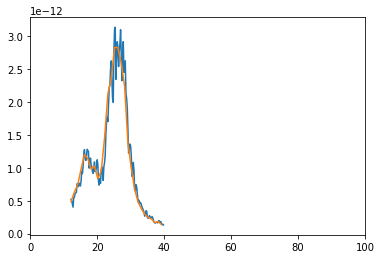

In [215]:
importlib.reload(specHelp)

psd = subBl['012'].LFP_R_0_1.psd
freqs = subBl['012'].LFP_R_0_1.psd_f

psd, freqs = specHelp.select_bandwidths(
    np.mean(psd, axis=0), freqs, f_min=12, f_max=40,
)

plt.plot(freqs, psd)

psd, freqs = specHelp.resample_spectral_freqs(
    psd, freqs, newBinWidth=1
)
plt.plot(freqs, psd)

plt.xlim(0, 100)
plt.show()

In [105]:
subData['012'].data_version

'v2.2'

In [120]:
subBl['013'].LFP_R_2_3.psd.shape

(0,)

In [116]:
### VISUALISE bilateral STN-PSD BASELINE VALUES

# TODO: plot STN-LFPs two subfigures, one STN per subfigure

importlib.reload(specBase)
importlib.reload(specFts)

fullSide = {'L': 'Left', 'R': 'Right'}

for sub in ['012', '013', '014']:

    blDat = subBl[sub]

    chN, chKeys = {}, {}

    for side in ['L', 'R']:

        chN[side], chKeys[side] = find_sourceKeys(
            vars(blDat).keys(), f'LFP_{side}'
        )

    fig, axes = plt.subplots(1, 2, figsize=(12, 6)
    )
    fs = 14

    for n, side in enumerate(['L', 'R']):

        for ch in chKeys[side]:
            try:
                axes[n].plot(
                    getattr(blDat, ch).psd_f,
                    np.mean(
                        getattr(blDat, ch).psd,
                        axis=0
                    ),
                    label=ch,
                )
            except ValueError:
                print(side, ch)
            axes[n].set_xlim(0, 100)
        
        axes[n].set_ylabel('Mean Spectral Power')
        axes[n].set_title(f'Baseline PSDs LFP {fullSide[side]}')
        axes[n].legend(frameon=False, ncol=len(chKeys[side]))


    plt.suptitle(
        f'{sub}: spectral baseline values',
        size=14 + 4, x=.5, y=.99, ha='center')

    # plt.tick_params(
    #     axis='both', labelsize=fs, size=fs, which='major')
    plt.tight_layout()

    fig_name = (
        f'{sub}_baseline_{subBl[sub].n_bl_minutes}Min_'
        f'{subBl[sub].nSec_Segm}sSegm_baseline_STN_PSDs'
    )
    plt.savefig(
        os.path.join(
            fig_dir,
            'ft_baselines',
            'ft_v2.2',
            fig_name
        ),
        dpi=150, facecolor='w',
    )

    plt.close()




/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


R LFP_R_2_3


### Create dopa-timed Feature Extraction and Visualisation

In [ ]:
# use feats_main.py

# use window length 5 sec

# create raw features and normalised features to baseline
    # PSD: plot as time-freq-plots
    # Coherences (iCoh and iCoh-detect) -> both raw and normalised against baseline

    # revise PAC

#### Manual Video-Movement Annotation

In [ ]:
# annotate observed taps in video, integers are seconds
# from video start
# CAVE: orignal Video-starttime is hour in front
# values here are corrected one hour backwards (12->11)
# Still the video-time seems to be +/- 3 minutes behind
# the acc-neurophys-time
taptimes_video = {
    'SelfpacedHandTapL_StimOffDopa15': {
        'left': [
            1154, 1160, 1164, 1169, 1174, 1180, 1185,
            1191, 1195, 1201, 1207, 1226, 1238, 1243,
            1248, 1253
        ],
        'right':[
            1260, 1264, 1270, 1275, 1281, 1290, 1298,
            1303, 1308, 1313, 1320, 1324, 1332, 1339,
            1345
        ],
        'starttime': '2021-11-15 11:29' 
        # original 11:26 but corrected for mismatching times
    },
    'SelfpacedHandTapL_StimOffDopa35': {
        'left': [
            878, 883, 888, 893, 898, 903, 908, 915,
            919, 926, 933, 946, 951, 957, 963, 970,
            976, 984
        ],
        'right':[
            1000, 1006, 1011, 1017, 1024, 1028, 1035,
            1041, 1054, 1060, 1081, 1089, 1097, 1103,
            1108
        ],
        'starttime': '2021-11-15 11:51:01'
        # original 11:48 but corrected for mismatching times
    },
    'SelfpacedHandTapL_StimOffDopa60': {
        'left': [
            641, 647, 652, 657, 662, 666, 671, 676,
            682, 686, 692, 697, 703, 708, 713, 719,
        ],
        'right':[
            726, 730, 734, 740, 746, 751, 756, 761,
            768, 773, 779, 784, 792, 797, 801
        ],
        'starttime': '2021-11-15 12:22:59'  # video S1290007
        # original 12:20 but corrected for mismatching times
    }
}
# add timedelta in seconds to start-time of video
# CAVE videostarttime is on MINUTE-RESOLUTION
# thus will be SECONDS OF FROM ACC-TIMESTAMP
for run in taptimes_video:
    starttime = pd.Timestamp(taptimes_video[run]['starttime'])
    for side in ['left', 'right']:
        taptimes_video[run][f'{side}_stamps'] = []
        for sec in taptimes_video[run][side]:
            delta = pd.Timedelta(sec, 'sec')
            taptimes_video[run][f'{side}_stamps'].append(
                starttime + delta)

# Save annotation dict
# deriv_dir = os.path.join(
#     projectpath, 'data', 'analysis_derivatives', 'sub-008', 'taps'
# )
# dict_name = f'008_video_ann_tapruns'
# np.save(os.path.join(deriv_dir, dict_name),
#         taptimes_video)

# # Load annotation dict
# video_taps = np.load(os.path.join(deriv_dir, f'{dict_name}.npy'),
#                      allow_pickle=True).item()


In [ ]:
sub = '008'
annot_dir = os.path.join(projectpath, f'data/analysis_derivatives/sub-{sub}/taps')
testannot = np.load(os.path.join(annot_dir, f'{sub}_video_ann_tapruns.npy'),
    allow_pickle=True).item()
# testannot


#### Automated Acc-based Tap detection incl. plotting

In [ ]:
run = 'SelfpacedHandTapL_StimOffDopa35'
sides = ['left', 'right']
tap_fig_dir = os.path.join(projectpath, 'figures/tapping_detection')

In [ ]:
importlib.reload(tap_run)

restTest, tapTest, _ = tap_run.runTapDetection(
    task='paused', fs=SUB08.runs[run].acc_right_Fs,
    leftxyz=[accleft[run][0, :], accleft[run][1, :],
    accleft[run][2, :]], rightxyz=[accright[run][0, :],
    accright[run][1, :], accright[run][2, :]],
)



START left side
1.121970047728486e-07 17 17
logAND is TRUE from rest 366
start of TAP/MOV 1.3276377210030713e-07 366
after lowpeak(UP) coming back up 384
endUP 388
START DOWN MOVEMENT 464
Fastest DOWN MOVEMENT 475
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
logAND is TRUE from rest 1511
start of TAP/MOV 1.1851244079397509e-07 1511
after lowpeak(UP) coming back up 1526
endUP 1539
START DOWN MOVEMENT 1607
Fastest DOWN MOVEMENT 1614
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
logAND is TRUE from rest 2500
start of TAP/MOV 1.303586646046799e-07 2500
after lowpeak(UP) coming back up 2515
endUP 2519
START DOWN MOVEMENT 2594
Fastest DOWN MOVEMENT 2604
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
logAND is TRUE from rest 3499
start of TAP/MOV 1.3153520968013539e-07 3499
after lowpeak(UP) coming back up 3512
endUP 3518
START DOWN MOVEMENT 3601
Fastest DOWN MOVEMENT 3611
ended MOVE bcs next10 inactive
ended MOV

In [ ]:
### Main function to perform TapDetection functions
    ## make new main-function

importlib.reload(Tap2)

# accright, accleft = {}, {}
# restDict, tapDict, moveDict = {}, {}, {}

for run in SUB08.runs_incl[1:]:
    print(f'Start RUN: {run}')
    fs=SUB08.runs[run].acc_right_Fs
    accright[run] = SUB08.runs[run].acc_right_arr[1:, :]
    accleft[run] = SUB08.runs[run].acc_left_arr[1:, :]

    restDict[run], tapDict[run], moveDict[run] = runTapDetection(
        task='paused', fs=SUB08.runs[run].acc_right_Fs,
        leftxyz=[accleft[run][0, :], accleft[run][1, :],
        accleft[run][2, :]], rightxyz=[accright[run][0, :],
        accright[run][1, :], accright[run][2, :]],
    )


Start RUN: SelfpacedHandTapL_StimOffDopa60


START left side
1.012731518833157e-07 17 14
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
logAND is TRUE from rest 946
start of TAP/MOV 1.1483229646828269e-07 946
after lowpeak(UP) coming back up 1048
endUP 1055
ended MOVE bcs next10 inactive
logAND is TRUE from rest 2131
start of TAP/MOV 1.2207354651560685e-07 2131
after lowpeak(UP) coming back up 2153
endUP 2157
START DOWN MOVEMENT 2229
Fastest DOWN MOVEMENT 2239
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
logAND is TRUE from rest 3107
start of TAP/MOV 1.2677018217050875e-07 3107
after lowpeak(UP) coming back up 3122
endUP 3126
START DOWN MOVEMENT 3195
Fastest DOWN MOVEMENT 3202
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
logAND is TRUE from rest 4029
start of TAP/MOV 1.2250273844703196e-07 4029
after lowpeak(UP) coming back up 4045
endUP 4050
START DOWN MOVEMENT 4106
Fastest DOWN MOVEMENT 4117
ended MOVE bc

In [ ]:
### (function to be) get runstartTimes (include in RUN CLASS (real and dopa times))
deriv_dir = os.path.join(projectpath, 'data/analysis_derivatives')
runTimes = pd.read_excel(
    os.path.join(deriv_dir, f'sub-{sub}', f'sub{sub}_runsInfo.xlsx'))

runStartTimes = {}
for run in SUB08.runs_incl:
    for row in np.arange(runTimes.shape[0]):
        if run[-6:] in runTimes.iloc[row]['filename']:
            t = runTimes.iloc[row]['acq_time']
            runStartTimes[run] = pd.Timestamp(t)

In [ ]:
### Import and process video-annotated tap-times ###

## (function to be) Convert video-annotated tap-stamps
## into seconds after tmsi-recording

# import annotated taptimes (function to be?)
sub = '008'
annot_dir = os.path.join(projectpath, f'data/analysis_derivatives/sub-{sub}/taps')
tapAnnot = np.load(os.path.join(annot_dir, f'{sub}_video_ann_tapruns.npy'),
    allow_pickle=True).item()

ann_times = {}
tapsAnnot_in_runSecs = {}

for run in tapDict.keys():
    if 'Tap' not in run: continue

    # real-time timestamps of video-annotated taps
    dt_string = '%Y-%m-%d %H:%M:%S'
    t0 = tapAnnot[run]['starttime']
    try:
        t0 = dt.datetime.strptime(t0, dt_string)
    except ValueError:
        t0 = dt.datetime.strptime(t0, '%Y-%m-%d %H:%M')

    ann_times[run] = {}
    tapsAnnot_in_runSecs[run] = {}

    for side in sides:
        ann_times[run][side] = [t0 + dt.timedelta(
            seconds=t) for t in tapAnnot[run][side]]
    # minus video start-time -> time after video-start
        tapsAnnot_in_runSecs[run][side] = [
            (t - runStartTimes[run]).total_seconds(
            ) for t in ann_times[run][side]
        ]


In [ ]:
### TO DO:
# - WHY IS check_Polarity turning the signal falsely?
# - Why is tapdetection from TapDopa15 Right empty? 
    # plot incl peaks and thresholds etc

# - include plotting of OTHER MVOEMENTS
# - split py function for tapping in several py docs!!

Plot Figure for run SelfpacedHandTapL_StimOffDopa15


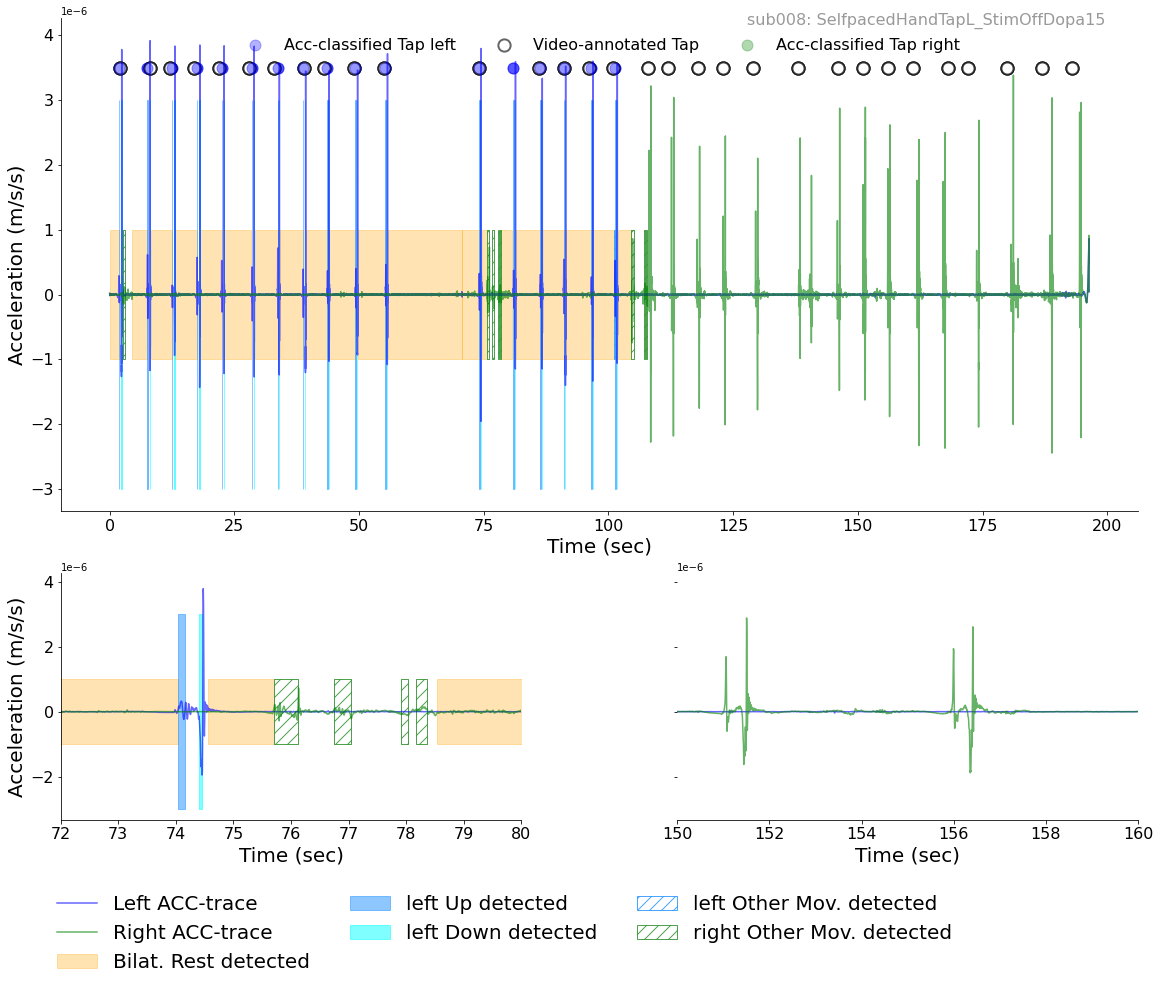

In [ ]:
### Create plotting functions for tapping

from matplotlib.gridspec import GridSpec

run = list(tapsAnnot_in_runSecs.keys())[2]

print(f'Plot Figure for run {run}')
# specify x-coordinates of zoomed-in subplots
ax1_x1, ax1_x2 = 72, 80
ax2_x1, ax2_x2 = 150, 160
plot_fname=f'TapDetect_08_{run}'
if ax1_x1: plot_fname += f'_zooms_{ax1_x1}_{ax2_x1}'
plot_fdir=tap_fig_dir

plot_params = {
        'left': {
            'color': 'b',
            'alpha': .6
        },
        'right': {
            'color': 'g',
            'alpha': .6
        },
        'rest': {
            'color': 'orange',
            'alpha': .3
        },
        'left_up': {
            'color': 'dodgerblue',
            'alpha': .5
        },
        'left_down': {
            'color': 'cyan',
            'alpha': .5
        },
        'left_other': {
            'facecolor': 'white',
            'edgecolor': 'dodgerblue',
            'alpha': .8,
            'hatch': '//'
        },
        'right_up': {
            'color': 'forestgreen',
            'alpha': .5
        },
        'right_down': {
            'color': 'lime',
            'alpha': .5
        },
        'right_other': {
            'facecolor': 'white',
            'edgecolor': 'forestgreen',
            'alpha': .8,
            'hatch': '//'
        }
    }

fig = plt.figure(constrained_layout=True, figsize=(16, 12))
gs = GridSpec(3, 9, figure=fig)

ax0 = fig.add_subplot(gs[:2, :])
ax1 = fig.add_subplot(gs[2, :4])
ax2 = fig.add_subplot(gs[2, 5:], sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)

for ax in [ax0, ax1, ax2]:
    # Plotting traces
    ax.plot(
        np.arange(0, accleft[run][1, :].shape[0]) / fs,
        accleft[run][1, :], **plot_params['left'],
        label='Left ACC-trace',
    )
    ax.plot(
        np.arange(0, accright[run][1, :].shape[0]) / fs,
        accright[run][1, :], **plot_params['right'],
        label='Right ACC-trace',
    )
    # Plot bilateral Rest-epochs
    for d in restDict[run]:
        ax.fill_betweenx(label='Bilat. Rest detected',
            y=[-1e-6, 1e-6], x1=restDict[run][d][0],
            x2=restDict[run][d][1],
            **plot_params['rest'],)

    # Plot Tap and other-movem. epochs
    for side in ['left', 'right']:
        ## plot Taps
        for t, tList in enumerate(tapDict[run][side]):
            ax.fill_betweenx(
                y=[-3e-6, 3e-6],
                x1=tList[0], x2=tList[2],
                label=f'{side} Up detected',
                **plot_params[f'{side}_up'],
            )
            # ax.scatter(tList[1], )  # plot fastest point
            ax.fill_betweenx(
                y=[-3e-6, 3e-6],
                x1=tList[3], x2=tList[4],
                label=f'{side} Down detected',
                **plot_params[f'{side}_down'],
            )
        
        ## Plot Other Movement's
        for t, tList in enumerate(moveDict[run][side]):
            ax.fill_betweenx(
                y=[-1e-6, 1e-6],
                x1=tList[0], x2=tList[1],
                label=f'{side} Other Mov. detected',
                **plot_params[f'{side}_other'],
            )
        
        ## Plot Accuracy circles based on video-annotations
        vid_circle_pos = tapsAnnot_in_runSecs[run][side]
        acc_circle_pos = [t[0] for t in tapDict[run][side]]
        ax0.scatter(
            vid_circle_pos, [3.5e-6] * len(vid_circle_pos),
            s=150, edgecolor='k', facecolor='w', lw=2,
            label='Video-annotated Tap', **plot_params['left'],
        )
        ax0.scatter(
            acc_circle_pos, [3.5e-6] * len(acc_circle_pos),
            s=120, color=plot_params[side]['color'], alpha=.3,
            label=f'Acc-classified Tap {side}'
        )
        tapAcc_handles, tapAcc_labels = ax0.get_legend_handles_labels()
        tapAcc_handles = tapAcc_handles[-3:]
        tapAcc_labels = tapAcc_labels[-3:]
        ax0.legend(tapAcc_handles, tapAcc_labels,
            fontsize=16, ncol=3, frameon=False,
            loc='upper center', bbox_to_anchor=(.5, .99))

        # plot findpeak dots to optimize algorithm
        # posPeaks = signal.find_peaks(
        #     accleft[run][1, :],
        #     height=np.max(accleft[1, :]) * .5,
        #     distance=fs,  # 1 s
        # )
        # ax.scatter(posPeaks[0] / fs, posPeaks[1]['peak_heights'], c='k')
        # posPeaks = signal.find_peaks(
        #     accright[run][1, :],
        #     height=np.max(accright[1, :]) * .5,
        #     distance=fs,  # 1 s
        # )
        # ax.scatter(posPeaks[0] / fs, posPeaks[1]['peak_heights'], c='gray')
        
        
    # make plots pretty
    ax.set_xlabel('Time (sec)', size=20)
    ax.tick_params(axis='both', which='both', labelsize=16)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # helping lines for alforithm finetuning
    # ax.axhline(np.median(spos), label='median')
    # ax.axhline(np.percentile(spos, 75), label='75-%', ls='dotted')
    # ax.axhline(-np.percentile(spos, 75), label='-75-%', color='red', ls='dotted')

# make plot pretty
for ax in [ax0, ax1]: ax.set_ylabel('Acceleration (m/s/s)', size=20)
ax2.spines['left'].set_visible(False)

# define zoomed subplots
ax1.set_xlim(ax1_x1, ax1_x2)
ax2.set_xlim(ax2_x1, ax2_x2)

# get rid off duplicate legend labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(
    by_label.values(), by_label.keys(),
    fontsize=20, frameon=False, ncol=3,
    loc='upper left', bbox_to_anchor=(.03, -.01)
)
plt.suptitle(f'sub008: {run}', x=.8, y=.99,
    color='gray', alpha=.8, fontsize=16,)
# plt.tight_layout(pad=.1)

plt.savefig(os.path.join(plot_fdir, plot_fname),
    dpi=150, facecolor='white', bbox_inches='tight')

plt.show()

In [ ]:
### PLOTTING ###
## using xyz input and output-indices of pausedTap function
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(xEpoch, label='x', alpha=.5, c='blue')
ax.plot(yEpoch, label='y', alpha=.8, c='green')
ax.plot(zEpoch, label='z', alpha=.5, c='orange')
# plot vertical lines at tap-moments
for t, tap in enumerate(tapi):
    if t == 0:
        ax.axvline(tap[0], c='green', ls='dotted', alpha=.5, label='start UP')
        ax.axvline(tap[1], c='green', ls='solid', alpha=.5, label='end UP')
        ax.axvline(tap[2], c='purple', ls='dotted', alpha=.5, label='start DOWN')
        ax.axvline(tap[3], c='purple', ls='solid', alpha=.5, label='end DOWN')
    else:
        ax.axvline(tap[0], c='green', ls='dotted', alpha=.5,)
        ax.axvline(tap[1], c='green', ls='solid', alpha=.5,)
        ax.axvline(tap[2], c='purple', ls='dotted', alpha=.5,)
        ax.axvline(tap[3], c='purple', ls='solid', alpha=.5,)

peaklabel = ['lowPos', 'highPos', 'lowNeg', 'highNeg']
peakcol = ['lightgreen', 'green', 'orange', 'r']
for p, peaks in enumerate([smallPos, largePos, smallNeg, largeNeg]):
    ax.scatter(
        peaks[0],
        yEpoch[peaks[0]],
        label=peaklabel[p],
        color=peakcol[p],
        s=50,
    )

for mov in movei:  # check saved otherMovements
    ax.axvline(mov[0], color='gray', lw=1, ls='dotted')
    ax.axvline(mov[-1], color='gray', lw=1)

# ax.axhline(-.5e-7)
ax.axhline(posThr)
ax.axhline(0, c='gray', lw=.5,)
# determine what to show
ax.set_ylim(-2.5e-6, 2.5e-6)
# ax.set_xlim(istart, istop)
ax.set_xlim(0, 30000)
# ax.set_xticks(np.arange(18600, 20001, 200))
# ax.set_xticklabels(np.arange(18600, 20001, 200) // 200)
xticks = np.arange(0, len(yEpoch), 6000)
xlabs = np.arange(0, len(yEpoch) / 12000, .5)
ax.set_xticks(xticks)
ax.set_xticklabels(xlabs)

ax.set_ylabel('Raw Acceleration (m/s/s)', size=14)
ax.set_xlabel('Time (minutes)', size=14)

ax.set_title(run)

# ax.legend(frameon=False, fontsize=14, loc='upper right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Plot Rest-moments
for idx in resti:
    ax.fill_betweenx(
        y=np.linspace(-3e-6, 3e-6, 5), x1=idx[0], x2=idx[1],
        color='blue', alpha=.1,)

if to_save:
    plt.savefig(
        os.path.join(temp_save, 'ACC', f'mountFingerTap_sub08_{run[-6:]}_2'),
        dpi=300, facecolor='w',
    )
plt.show()

print(f'{run} finisihed')

169.42

In [ ]:
tempdir = ('/Users/jeroenhabets/Research/CHARITE/projects/'
    'dyskinesia_neurophys/data/analysis_derivatives/sub-008/May03')


In [ ]:
def SelAndSave_Restblocks(
    neu_data, fs, neu_names, restTimes, runname, winlen=1024,
    neu_ch_incl=[],
):
    for neu_chi in np.arange(1, neu_data.shape[0]):
        neudat = neu_data[neu_chi, :]
        neuTimes = neu_data[0, :]
        neu_ch = neu_names[neu_chi]  # channel name
        print(neu_ch)
        if neu_ch_incl:
            if neu_ch not in neu_ch_incl: continue

        tempdat = np.zeros((1, winlen))
        rowTimes = []  # list to store times corresponding to data rows

        for n, timeIdx in enumerate(restTimes[1:-1]):  # skip first and last
            neuInd1 = np.where(neuTimes == timeIdx[0])[0][0]
            neuInd2 = np.where(neuTimes == timeIdx[1])[0][0]
            dat_sel = neudat[neuInd1:neuInd2]
            n_wins = len(dat_sel) // winlen
            dat_sel = np.reshape(
                dat_sel[:n_wins * winlen],
                (n_wins, winlen),
                order='C',  # fills row after row
            )
            tempdat = np.vstack([tempdat, dat_sel])
            for i in np.arange(n_wins):
                rowTimes.append(timeIdx[0] + (i * winlen / fs))

        rowTimes = np.round(rowTimes, 3)  # round .019999 values
        tempdat = tempdat[1:, :]  # exclude first row of zeros

        # saving data array
        fname = f'{runname}_{neu_ch}_win{winlen}'
        # np.save(os.path.join(
        #     tempdir, 'restblocks', f'restBlocks_sub08_{fname}'), tempdat)
        # save list of rowtimes
        np.save(os.path.join(
            tempdir, 'restblocks', f'restTimes_sub08_{fname}'), rowTimes)


    # return tempdat, rowTimes

In [ ]:
neusource = 'lfp_left'
_, _ = SelAndSave_Restblocks(
    neu_data = getattr(SUB08.runs[run], f'{neusource}_arr'),
    fs = getattr(SUB08.runs[run], f'{neusource}_Fs'),
    neu_names = getattr(SUB08.runs[run], f'{neusource}_names'),
    restTimes=restTimes,
    runname=run[-6:],
)

'''
IMPORTANT: CHECK VIDEO - TMSi TIME DIFF
# second left-mov (tap) in video at 19:19
# -> video Timestamp('2021-11-15 11:45:20')
# -> acc from 2021-11-15 11:48:19.395000 
#           to 2021-11-15 11:48:20.300000

# first right-mov (dysk) in video at 19:14
#  -> video Timestamp('2021-11-15 11:47:00')
#  -> acc from 2021-11-15 11:48:14.505000
#           to 2021-11-15 11:48:16.040000

# Rest recording starts in video at 12:52
# -> video first movements right between 13:00 +/- 00:02:
#   stamp is 11:26:00 + 00:13:00 -> 11:39:00 +/- 00:02
# IN ACC: 11:42:00 +/- 00:02
# ERGO: For Rest10, Tapping15: ACC-time is 03:00 ahead of Video